# Sentiment Analysis of ARA Corpus

**Outline:**
1. Read raw data
2. Text preprocessing & cleaning
3. Document representation (feature vectors)
4. Build sentiment classifier based on BOW vectors
5. Build sentiment classifier based on fasstext vectors

**What you need to do:** 
- Read and execute the source code below and answer the questions in **EXERCISE 1 - EXERCISE 4**.
- **Submit** the modifiled file ``TD3.ipynb`` on google drive.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

# set the font size of plots
plt.rcParams['font.size'] = 14

In [3]:
np.set_printoptions(precision=3)

*****

## Read corpus
We are going to use a different corpus. This corpus is already labelled.

In [4]:
corpus_files = [ './sentiment_data_ARA_pos.txt', './sentiment_data_ARA_neg.txt' ]

In [5]:
def read_text_file(filename):
    print('Reading file ' + filename + "...")
    with open(filename, "r", encoding='utf8') as textfile:
        L = []
        for line in textfile:
            L.append(line.strip())
        print('File contains ', len(L), "lines.\n")
        return L

In [6]:
ara_corpus_pos = read_text_file(corpus_files[0])
ara_corpus_neg = read_text_file(corpus_files[1])

Reading file ./sentiment_data_ARA_pos.txt...
File contains  6000 lines.

Reading file ./sentiment_data_ARA_neg.txt...
File contains  4898 lines.



In [7]:
## Verify corpus

type(ara_corpus_pos),type(ara_corpus_neg)

(list, list)

In [8]:
len(ara_corpus_pos),len(ara_corpus_neg)

(6000, 4898)

In [9]:
print(ara_corpus_pos[0])
print(ara_corpus_neg[0])

مكان الرجل الحقيقي كل شي نضيف واصلي وماركات ...صح غالي شوي بس لبس روعه
المحادثات المخفية المحادثات المخفية الخاصية دي اتلغت ليه ممكن حد يفهمني


In [10]:
## Combine pos and neg corpus into a single corpus for easy manipulation

ara_corpus = ara_corpus_pos + ara_corpus_neg
ara_corpus_sentiment = len(ara_corpus_pos)*[1] + len(ara_corpus_neg)*[-1]

In [11]:
len(ara_corpus),len(ara_corpus_sentiment)

(10898, 10898)

***

## Text Preprocessing & Cleaning

We are going to follow the same pipeline of TD1, except that here the operations should be **adapted to the Arabic language** (instead of the French language).

1. Remove useless characters (using ``cleanup_text`` function from TD2)
2. Language identification and filtering (using language identification model from TD2)
3. Letter normalization
4. Tokenization
5. Remove stop words
6. Word normalization (stemming)
7. Remove words that are too short or too long.

### EXERCISE 1

Apply the above text cleaning operations by completing the code below (follow the instructins in the comments).

**However in order to save time, you will skip some steps in class and complete them at home.**

In [12]:
## COMPLETE THE SOURCE CODE IN THE CELLS BELOW. FOLLOW THE INSTRUCTIONS AND HINTS GIVEN IN THE COMMENTS.


In [13]:
##1. Remove useless characters using cleanup_text function from TD2

# YOU CAN MODIFY THIS FUNCTION AS NEEDED.
# FOR EXAMPLE, REMOVE NUMBERS ...

import re
import html

# regexp for word elongation: matches 3 or more repetitions of a word character.
two_plus_letters_RE = re.compile(r"(\w)\1{1,}", re.DOTALL)
three_plus_letters_RE = re.compile(r"(\w)\1{2,}", re.DOTALL)
# regexp for repeated words
two_plus_words_RE = re.compile(r"(\w+\s+)\1{1,}", re.DOTALL)


def cleanup_text(text):
    # Remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)

    # Remove user mentions of the form @username
    text = re.sub('@[^\s]+', '', text)
    
    # Replace special html-encoded characters with their ASCII equivalent, for example: &#39 ==> '
    if re.search("&#",text):
        text = html.unescape(text)

    # Remove special useless characters such as _x000D_
    text = re.sub(r'_[xX]000[dD]_', '', text)

    # Replace all non-word characters (such as emoticons, punctuation, end of line characters, etc.) with a space
    text = re.sub('[\W_]', ' ', text)

    # Remove redundant white spaces
    text = text.strip()
    text = re.sub('[\s]+', ' ', text)

    # normalize word elongations (characters repeated more than twice)
    text = two_plus_letters_RE.sub(r"\1\1", text)

    # remove repeated words
    text = two_plus_words_RE.sub(r"\1", text)

    return text

# unit test of this function
print(ara_corpus[0])
print(cleanup_text(ara_corpus[0]))

مكان الرجل الحقيقي كل شي نضيف واصلي وماركات ...صح غالي شوي بس لبس روعه
مكان الرجل الحقيقي كل شي نضيف واصلي وماركات صح غالي شوي بس لبس روعه


In [14]:
# Apply this function to each document in the corpus
ara_corpus_clean = [cleanup_text(doc) for doc in ara_corpus]

In [15]:
assert(len(ara_corpus_clean)==len(ara_corpus))
print(ara_corpus_clean[0])
print(len(ara_corpus_clean), len(ara_corpus))

مكان الرجل الحقيقي كل شي نضيف واصلي وماركات صح غالي شوي بس لبس روعه
10898 10898


In [16]:
##2. Language identification and filtering
# You should just the machine-learning based model that you constructed in TD2 (load it from a file)

# MODIFY THIS STEP AT HOME AS EXPLAINED ABOVE.

# Remove the code below later
# Quick method to save time in class: remove documents that contain more than 40% latin characters
MAX_LAT_FRAC = 0.3
ara_corpus_clean = [doc for doc in ara_corpus_clean if (len(re.findall('[a-zA-Z]',doc)) / len(doc)) < MAX_LAT_FRAC]


In [17]:
assert(len(ara_corpus_clean)<=len(ara_corpus))
print(len(ara_corpus),len(ara_corpus_clean))
print(ara_corpus_clean[0])

10898 10773
مكان الرجل الحقيقي كل شي نضيف واصلي وماركات صح غالي شوي بس لبس روعه


In [18]:
##3. Letter normalization
# Hint: which Arabic letters are equivalent n social media text?  e.g. alef, tah marbuta, dhad and dhad toushel, etc.

def normalizeArabic(corpus):
    corpus = re.sub("ة", "ت", corpus)
    corpus = re.sub("ض", "ظ", corpus)
    corpus = re.sub("ى", "ي", corpus)
    corpus = re.sub("ؤ", "ء", corpus)
    corpus = re.sub("ئ", "ء", corpus)
    corpus = re.sub("[إأٱآا]", "ا", corpus)
    return(corpus)

ara_corpus_clean =  [normalizeArabic(doc) for doc in ara_corpus_clean]


In [19]:
##4. Tokenization -- Complete code below (same as in TD1)

# COMPLETE THE CODE BELOW

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('[^_\W]+')
ara_corpus_tokenized = [tokenizer.tokenize(doc) for doc in ara_corpus_clean]


In [20]:
type(ara_corpus_tokenized)

list

In [21]:
# verify corpus after tokenization
assert(len(ara_corpus_clean) == len(ara_corpus_tokenized))
assert(type(ara_corpus_tokenized[0]) == list and type(ara_corpus_tokenized[0][0]) ==str)
type(ara_corpus_tokenized[0]), type(ara_corpus_tokenized[0][0])

(list, str)

In [22]:
# verify first document in corpus
ara_corpus_tokenized[0]

['مكان',
 'الرجل',
 'الحقيقي',
 'كل',
 'شي',
 'نظيف',
 'واصلي',
 'وماركات',
 'صح',
 'غالي',
 'شوي',
 'بس',
 'لبس',
 'روعه']

In [23]:
##5. Remove stop words -- based on a 'standard' list of stopwords for the Arabic language.

# COMPLETE THE CODE BELOW  (See TD1)
import nltk
nltk.download('stopwords')
# Load stop words from NLTK library
from nltk.corpus import stopwords
stop_words_ar = stopwords.words('arabic')
type(stop_words_ar),len(stop_words_ar)
print(stop_words_ar[0:10])

# FEEL FREE TO ADD MORE WORDS TO THIS LIST IF YOU WANT ...
set(stop_words_ar) & {'من','إلى','عن','على','في','ب','ل','ك','و'}
stop_words_ar = stop_words_ar + ['من','إلى','عن','على','في','ب','ل','ك','و']
type(stop_words_ar)
# For each document, remove stop words
ara_corpus_tokenized = [[word for word in doc if word not in stop_words_ar] for doc in ara_corpus_tokenized]



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي']


In [24]:
# verify corpus after removing stop words
assert(len(ara_corpus_clean) == len(ara_corpus_tokenized))
assert(type(ara_corpus_tokenized[0]) == list and type(ara_corpus_tokenized[0][0]) ==str)

In [25]:
# verify first document
ara_corpus_tokenized[0]

['مكان',
 'الرجل',
 'الحقيقي',
 'شي',
 'نظيف',
 'واصلي',
 'وماركات',
 'صح',
 'غالي',
 'شوي',
 'لبس',
 'روعه']

In [26]:
##6. Stemming
# Hints: stemming is a difficult task for the Arabic language because words are often combined into one word (called agglutination).
#     You should first visually inspect all the words in your corpus to get an idea about which words are good candidates for stemming ...
#     Then try to think of a few simple stemming heuristics (regular expressions), such as: remove certain prefixes (e.g. al), remove certain suffixes (e.g. 'ouna') ...

# SKIP THIS STEP IN CLASS TO SAVE TIME. COMPLETE IT AT HOME.
import argparse
from nltk.stem.isri import ISRIStemmer

def light_stem(text):
    words = text.split()
    result = list()
    stemmer = ISRIStemmer()
    for word in words:
        word = stemmer.norm(word, num=1)      # remove diacritics which representing Arabic short vowels
        if not word in stemmer.stop_words:    # exclude stop words from being processed
            word = stemmer.pre32(word)        # remove length three and length two prefixes in this order
            word = stemmer.suf32(word)        # remove length three and length two suffixes in this order
            word = stemmer.waw(word)          # remove connective ‘و’ if it precedes a word beginning with ‘و’
            word = stemmer.norm(word, num=2)  # normalize initial hamza to bare alif
        result.append(word)
    return ' '.join(result)

ara_corpus_clean =  [light_stem(doc) for doc in ara_corpus_clean]
ara_corpus_tokenized =  [tokenizer.tokenize(doc) for doc in ara_corpus_clean]
ara_corpus_tokenized[0]



['مكان',
 'رجل',
 'حقيقي',
 'كل',
 'شي',
 'نظيف',
 'واصلي',
 'ومارك',
 'صح',
 'غالي',
 'شوي',
 'بس',
 'لبس',
 'روعه']

In [27]:
##7. Remove words that are too short or too long.
# Very short words are usually not very meaningful.
# Very long words are usually either wrong, or elongated, or derived words that should be stemmed (normalized).

# ENTER YOUR CODE BELOW. See TD1.

distinct_words = {word for doc in ara_corpus_tokenized for word in doc}
type(distinct_words),len(distinct_words)

words_len = pd.Series([len(word) for word in distinct_words])
words_len.describe()


count    48703.000000
mean         5.063548
std          1.421948
min          1.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         30.000000
dtype: float64

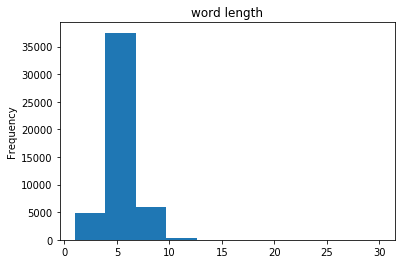

In [28]:
fig = words_len.plot(kind='hist', title="word length")

In [29]:
ara_corpus_tokenized = [[word for word in doc if len(word)>=4] for doc in ara_corpus_tokenized]
type(ara_corpus_tokenized),len(ara_corpus_tokenized)




(list, 10773)

****

In [30]:
ara_corpus_tokenized = [[word for word in doc if len(word)<=12] for doc in ara_corpus_tokenized]
type(ara_corpus_tokenized),len(ara_corpus_tokenized)

(list, 10773)

## Document Representation
Remember that the goal of this step is to transform each document from a list of words to a numeric *feature vector*. Each feature corresponds to a distinct word in a selected vocabulary. These feature vectors are stored in a numeric matrix called the **Document-Term Matrix (DTM)**.

We will achieve this using *tfidf-BOW* method, as we did in **TD1**.

In [31]:
# EXECUTE THE CODE BELOW THEN ANSWER THE QUESTIONS IN THE EXERCISE.


#### Prepare the corpus for BOW

In [32]:
# First, concatenate the words in the cleaned corpus (because BOW method in scikit-learn requires this format)
ara_corpus_bow = [' '.join(doc) for doc in ara_corpus_tokenized]

In [33]:
assert(len(ara_corpus_tokenized)==len(ara_corpus_bow))

In [34]:
print(ara_corpus_tokenized[0])

['مكان', 'حقيقي', 'نظيف', 'واصلي', 'ومارك', 'غالي', 'روعه']


In [35]:
print(ara_corpus_bow[0])

مكان حقيقي نظيف واصلي ومارك غالي روعه


#### Build the vocabulary set
Extract the vocabulary set from our corpus and calculate IDF values of each word in this set.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
# Configuration parameters of the BOW model
# FEEL FREE TO MODIFY THESE PARAMETERS AS NEEDED ...
max_words = 10000
maxdf = 0.7
mindf = 5

In [38]:
# create an instance of this class
bow_model = TfidfVectorizer(max_df=maxdf, min_df=mindf, max_features=max_words, stop_words=[], use_idf = True)

In [39]:
# call fit() method in order to prepare BOW method (determine vocabulary and IDF values)
bow_model.fit( ara_corpus_bow )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=10000, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=[], strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

#### Build the DTM matrix

In [40]:
# Call the transform method in order to calculate DTM matrix of our corpus
ara_bow_dtm = bow_model.transform(ara_corpus_bow)

In [41]:
# Verify the type and size of this matrix
print(type(ara_bow_dtm))
print(ara_bow_dtm.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(10773, 8365)


#### Visually inspect the vocabulary
This should help you **tune** the BOW configuration parameters (i.e. min_df, max_df, etc.) ...

In [42]:
# The vocabulary of BOW -- i.e. the words that were selected by BOW method to be in the vocabulary
bow_vocab = bow_model.get_feature_names()
type(bow_vocab), len(bow_vocab)

(list, 8365)

In [43]:
# The words that were ignored (and were not included in the vocabulary)
ignored_words = bow_model.stop_words_
type(ignored_words),len(ignored_words)

(set, 35358)

In [44]:
# DON'T DO THIS !!! THERE ARE TOO MANY IGNORED WORDS
ignored_words

{'بحتار',
 'زكيه',
 'تارجت',
 'عنفا',
 'تهذي',
 'ولابس',
 'جواهر',
 'ميتي',
 'بلادت',
 'سلبيه',
 'ويحفظك',
 'صفارت',
 'تتفظل',
 'اختارت',
 'ايرنيس',
 'يتعافي',
 'لاتفتح',
 'رقاويه',
 'سباغيتي',
 'وبكير',
 'فبرظت',
 'بخطءي',
 'نتفا',
 'وبرشلونت',
 'بغيته',
 'ارباعه',
 'ونسدد',
 'بنقص',
 'انمغصت',
 'تشحت',
 'زوال',
 '1429لم',
 'مربعا',
 'باعمار',
 'وببنود',
 'دفتر',
 'ماجيت',
 'يللي',
 'تاسيساتي',
 'اخوانه',
 'بقرص',
 'لقرار',
 'تناثر',
 'بتحسس',
 'وجماله',
 'اسما',
 'بمسرحيت',
 'ريءس',
 'خططا',
 'كماهو',
 'بلدك',
 'مدفءت',
 'بحقيقت',
 'مسيره',
 '2130',
 'وبشاشت',
 'لبنت',
 'يطعمونه',
 'اوثوريتي',
 'امجاد',
 'بيارت',
 'صامد',
 'نتركه',
 'سنتظرونك',
 'شهري',
 'قصدت',
 'ب990فلس',
 'بتزي',
 'ولويه',
 '150يورو',
 'لسباك',
 'ازدهاره',
 'مزدوجه',
 'لحرص',
 'سيعتن',
 'دوامت',
 'مهملت',
 'تلاجت',
 'ماسلا',
 'مبذولت',
 'هدفه',
 'بمرافق',
 'وخيالي',
 'لابءس',
 'مبللا',
 'بمشوك',
 'بناطيل',
 'ليليه',
 'ومعاك',
 'فالصباح',
 'تهدهد',
 'باتوبيس',
 'نشحد',
 'ويقعد',
 'اﻵهتمام',
 'حشوات',
 'علتي',
 'تغم

In [45]:
# Put vocavulary and their IDF values in a data frame
df = pd.DataFrame(dict(Word=bow_vocab,IDF=bow_model.idf_))

In [46]:
df.head(50)

,Word,IDF
0,1200,8.338981
1,1500,8.338981
2,1800,8.493132
3,2007,8.338981
4,2008,7.645834
5,2009,7.719942
6,2010,6.729543
7,2011,6.571319
8,2012,5.522717
9,2013,5.994432


In [47]:
df.tail()

,Word,IDF
8360,يوميه,8.087667
8361,يونيو,7.066015
8362,٢٠١٣,8.338981
8363,٢٠١٤,8.205450
8364,ﻻيوجد,8.493132


In [48]:
# Show vocabulary words that have SMALLEST IDF values (i.e. that have the largest document frequencies)
df.sort_values("IDF", inplace=False, ascending = True).head(10)

,Word,IDF
4547,فندق,2.024915
6212,مكان,2.581432
4764,كانت,2.723249
3206,راءع,2.753339
2974,خدمت,2.844744
6784,هناك,2.905883
4333,غرفت,2.914031
7656,ولكن,3.025775
5987,مطعم,3.055777
836,التي,3.134974


In [49]:
# Show vocabulary words that have LARGEST IDF values (i.e. that have the smallest document frequencies)
df.sort_values("IDF", inplace=False, ascending = False).head(10)

,Word,IDF
8364,ﻻيوجد,8.493132
5887,مسليه,8.493132
1100,اوركيد,8.493132
4373,فاتحت,8.493132
4376,فاتيك,8.493132
4378,فاجاب,8.493132
4379,فاخبر,8.493132
4386,فارسي,8.493132
4395,فاصل,8.493132
4401,فالجميع,8.493132


In [50]:
# If you want, you can save the vocabulary into a file
df.sort_values("IDF", inplace=False, ascending = True).to_csv("./bow_vocab.csv", index=False, header=True)

#### Remove documents that do not contain any vocabulary terms
i.e. remove rows in the DTM that are all zeros.

In [51]:
nb_terms_per_doc = np.array((ara_bow_dtm>0).sum(axis=1))  # calculate sum of rows of DTM matrix
nb_terms_per_doc = nb_terms_per_doc.ravel()  # convert result to a 1D array (instead of 2D array)
ara_bow_dtm.shape,nb_terms_per_doc.shape

((10773, 8365), (10773,))

In [52]:
pd.Series(nb_terms_per_doc).describe()

count    10773.000000
mean        27.265571
std         25.753605
min          0.000000
25%          9.000000
50%         21.000000
75%         36.000000
max        369.000000
dtype: float64

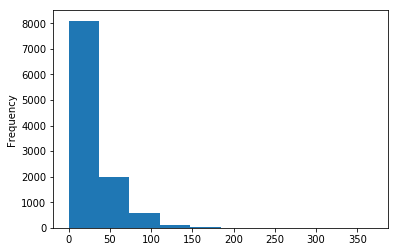

In [53]:
pd.Series(nb_terms_per_doc).plot(kind='hist')

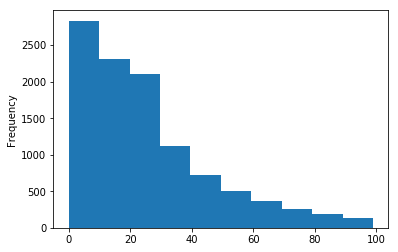

In [54]:
pd.Series(nb_terms_per_doc[nb_terms_per_doc<100]).plot(kind='hist')

In [55]:
# Number of documents that contain LESS THAN 5 vocabulary term
np.sum(nb_terms_per_doc<=5)

1784

In [56]:
# Number of documents that contain ZERO vocabulary terms
np.sum(nb_terms_per_doc==0)

107

In [57]:
# Which documents have length 0? (i.e. contain 0 words)
[doc for i,doc in enumerate(ara_corpus_bow) if nb_terms_per_doc[i]==0]

['خطاه خيرلامي',
 '',
 'وبالتوفيق',
 'وطنا',
 '',
 'هنجم',
 '',
 'مفيده',
 'جيــد',
 'مبرو مبروك',
 '',
 'فاوفي',
 '',
 'ممتاازت',
 'يابطل',
 'حميلت',
 'بودرت كوﻻج',
 '',
 'ياابوجلال وخلي يشرب لاتخلوه يطرش ويخرج خبابير احسل ياابوجلال هنجمه',
 '',
 'تاجرت صادقت',
 'واحببته',
 '',
 'يسلموو',
 '',
 'مزبله تاريـخ',
 'ممــتازت',
 'متوافقه',
 'ممتاززت',
 '',
 'حميل',
 '',
 'كتابه ماعم براسل',
 'ارحم',
 'حتودو داهيت',
 'ياخروف',
 'جيلك نهرظت',
 '',
 '',
 'كسمك',
 '',
 '',
 'خاين',
 '',
 'كداب',
 '',
 'تفريخ لجان',
 'لافتح معاملتك تصرفاتك',
 'اسكت توتو',
 'بهيمه',
 '',
 'خراط',
 'معترظ',
 'تقتل قتيل وتمش جنازته',
 'دمنا وبره',
 'يادنبوع',
 'ينفعش',
 'اخرف',
 'قرعه',
 'ثعاب وترويظ ياعبدربت',
 '',
 '',
 'كسمك',
 'انعل مرشدك',
 'معترظ',
 'انطق اخبل',
 '',
 'عبيط',
 '',
 'هيحرق',
 'عزاء',
 'لالا',
 '',
 'هتحرق',
 'كفايـت نهظـت',
 '',
 'هتحرقو',
 'طرطور',
 '',
 '',
 'نيفسك تهفك',
 '',
 'تصلحو موبايلات تبدلو',
 '',
 'زحممه دمرت وصخو وكسرو',
 '',
 '',
 'زحممه دمرت وصخو وكسرو',
 '',
 'تابليت',
 'ماتشت

In [58]:
idx = nb_terms_per_doc>0
ara_bow_dtm_filt = ara_bow_dtm[nb_terms_per_doc>0,:]
ara_corpus_bow_filt = [ara_corpus_bow[i] for i,x in enumerate(idx) if x]
ara_corpus_sentiment_filt = [ara_corpus_sentiment[i] for i,x in enumerate(idx) if x]

In [59]:
ara_bow_dtm.shape,len(ara_corpus_bow)

((10773, 8365), 10773)

In [60]:
ara_bow_dtm_filt.shape,len(ara_corpus_bow_filt),len(ara_corpus_sentiment_filt)

((10666, 8365), 10666, 10666)

### EXERCISE 2

Answer the following questions based on visual inspection of the above results:

1. How many words are then in the BOW vocabulary and how many words were ignored?
2. Give examples of 5 words in the vocabulary set of BOW but are not very useful for machine learning.
3. Give examples of 5 words that are **not** in the voabulary of BOW but might be useful.
4. Give examples of 5 words in the vocabulary set of BOW that are useful but should be stemmed or normalized.
5. Propose new values of the configuration parameters of BOW in order to tune the vocabulary to be more satisfactory. 

**Important Remarks**:
- Your answer to all questions will depend on how you do **text cleaning**. So you should rectify your answers after completing text cleaning part (at home).
- Your answer to Q4 will be quite **subjective**, so you just need to justify your choice. 


#1
The number of words in the BOW vocabulary =8327
The number of words that were ignored = 34790
#2
االي	
اءتم
حن 
طظ
#3
'فااشلت'
'منعو'
'موحشه'
'لاقلق'
'صرخ'
#4
عزيزي
ممتازت
#5
maxdf = 0.8
mindf = 10

******

## Build Sentiment Classifier
We will use the machine learning approach, i.e. train a classifier.

In [61]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [62]:
X = ara_bow_dtm_filt
y = ara_corpus_sentiment_filt

In [63]:
# Split the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1996)

In [64]:
print(X_train.shape)
print(len(y_train))
print(X_test.shape)
print(len(y_test))
assert(len(y_test)+len(y_train)==len(y))

(7466, 8365)
7466
(3200, 8365)
3200


### Train classifier using logistic regression

In [65]:
# Read documentation
# ?LogisticRegression

In [66]:
# Train the model using Logistic Regression method

LR_model = LogisticRegression(penalty='l2')
LR_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
# Use this model to predict the sentiment category of test documents
y_pred_LR = LR_model.predict(X_test)

In [68]:
type(y_pred_LR),len(y_pred_LR)

(numpy.ndarray, 3200)

In [69]:
# Calculate the classification rate of this classifier
metrics.accuracy_score(y_test, y_pred_LR)

0.8803125

In [70]:
# Display the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_LR))

[[1223  201]
 [ 182 1594]]


### Interpret parameter values of  this model
- The logistic regression model has one parameter per feature (i.e. vocabulary word).
- Most positive values indicate parameters that contribute most to class 1
- Most negative values indicate parameters contribute most to class -1

In [71]:
# Re-train the model using ALL DATA
LR_model2 = LogisticRegression(penalty='l2')
LR_model2.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
# get the coefficients (parameter) of the LR model
LR_coefs = LR_model2.coef_   #2D array with only one row
LR_coefs = LR_coefs.ravel()  #convert to a 1D array
print(type(LR_coefs))
print(LR_coefs.shape)

<class 'numpy.ndarray'>
(8365,)


In [73]:
# Verify that the number of coefficients = number of words in vocabulary
assert(len(bow_model.get_feature_names())==len(LR_coefs))

In [74]:
# Put the coefficients in a Pandas Series for ease of visualization
pd.Series(LR_coefs).describe()

count    8365.000000
mean        0.015516
std         0.465373
min        -7.097766
25%        -0.182381
50%         0.006523
75%         0.192966
max         8.067931
dtype: float64

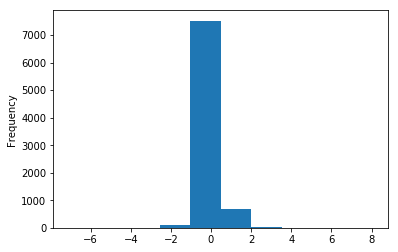

In [75]:
pd.Series(LR_coefs).plot(kind='hist')

In [76]:
## COMPLETE THE CODE BELOW BASED ON THE INSTRUCTIONS IN THE COMMENTS.
# HINT: put the coefficients and the vocabulary words in a Pandas DataFrame ...


# 1) Sort coefficient values in ascending order
dfc = pd.DataFrame(dict(Word=bow_vocab, Coef=LR_coefs))
dfc = dfc.sort_values("Coef", inplace=False, ascending = True)

# 2) Display the 20 largest coefficients and their corresponding words
dfc.tail(20)

,Word,Coef
5134,لطيف,2.516767
3810,شكرا,2.532786
7011,وانصح,2.565476
2694,جميله,2.574724
3355,روعه,2.623594
6328,مناسبت,2.761679
3234,راقي,2.771645
344,اروع,2.773280
742,افظل,2.850215
2689,جميع,2.908104


In [77]:
# 3) Display the 20 smallest coefficients and their corresponding words
dfc.head(20)

,Word,Coef
3674,سيءت,-7.097766
509,اسوا,-4.616624
49,ابدا,-4.264613
508,اسوء,-3.535722
4107,عادي,-3.518342
3675,سيءه,-3.516525
4654,قذرت,-2.631641
5388,مبالغ,-2.625203
4648,قديم,-2.419248
599,اطلاق,-2.344333


### EXERCISE 3

Answer the following questions based on the results of the logistic regression model.

1. Based on the *confusion matrix* above, is this classifier **biased**?  Note: we say a classifier is *biased* if it makes *significantly* more errors for one class than the other (false positives vs. false negatives).
2. Which 5 words are most aossicatd with positive sentiment?  (hint: see most positive coefficients)
3. Which 5 words are most aossicatd with negative sentiment?  (hint: see most negative coefficients)
4. Do these results make sense?  (if they don't, then there is something wrong with the data and/or processing pipeline ...)
5. (OPTIONAL) Show all test documents that are positive but are predicted negative by this classifier. Do you notice any trends?
6. (OPTIONAL) Show all test documents that are negative but are predicted positive by this classifier. Do you notice any trends?

#1 
In binary classification, the count of true negatives is C(0,0) , false negatives is C(1,0) , true positives is C(1,1) and false positives is C(0,1).
In our case : false negatives = 182
              false positives = 201              
Based on the confusion matrix above ,the classifier is a little biased.

#2  
راءع
راءعت
ممتازت
ممتاز
جميل

#3 
سيءت
اسوا
ابدا
اسوء
عادي

#4
yes the results make sense.

### Train classifier using Naive Bayes

In [78]:
# read documentation
# ?MultinomialNB

In [79]:
## Build Naive Bayes classification model

NB_model = MultinomialNB(alpha = 1.0)
NB_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [80]:
# Use this model to predict the sentiment category of test documents
y_pred_NB = NB_model.predict(X_test)

In [81]:
# Classification rate
metrics.accuracy_score(y_test, y_pred_NB)

0.8671875

In [82]:
# Confusion matrix
metrics.confusion_matrix(y_test, y_pred_NB)

array([[1123,  301],
       [ 124, 1652]], dtype=int64)

### Interpret parameters of  the model
- Naive Bayes model has two parameters per feature (i.e. vocabulary word)
- These parameters are stored in a 2x$n$ array, where $n$ is the number of vocabulary words
- The first row of this array contains **log of conditional probabilities** Pr(xi|class1)
- The second row contains **log of conditional probabilities** Pr(xi|class2)
- Ideally, if parameter value $\approx$ 0 then the corresponding vocabulary word is very important for that class
- Ideally, if parameter value $\approx - \infty$ then the corresponding vocabulary word is not important at all for that class

In [83]:
# Re-train the model using ALL DATA
NB_model2 = MultinomialNB(alpha = 1.0)
NB_model2.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [84]:
# get NB model's coefficients
NB_coefs = NB_model2.feature_log_prob_
print(type(NB_coefs))
print(NB_coefs.shape)

<class 'numpy.ndarray'>
(2, 8365)


In [85]:
assert(NB_coefs.shape[0] == 2)
assert(NB_coefs.shape[1] == len(bow_model.get_feature_names()))

In [86]:
# determine the order of classes in this model
NB_model2.classes_

array([-1,  1])

In [87]:
# paramaters associated with the NEGATIVE class
NB_coefs_neg_class = NB_coefs[0,:]

In [88]:
# paramaters associated with the POSITIVE class
NB_coefs_pos_class = NB_coefs[1,:]

In [89]:
pd.Series(NB_coefs_neg_class).describe()

count    8365.000000
mean       -9.374079
std         0.685892
min       -10.262439
25%        -9.847389
50%        -9.532099
75%        -9.070893
max        -5.017771
dtype: float64

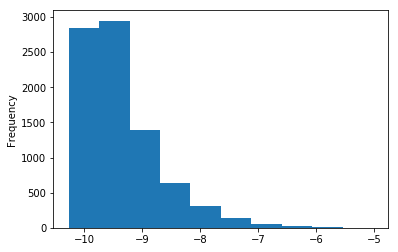

In [90]:
pd.Series(NB_coefs_neg_class).plot(kind='hist')

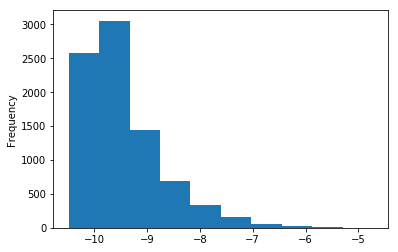

In [91]:
pd.Series(NB_coefs_pos_class).plot(kind='hist')

In [92]:
## COMPLETE THE CODE BELOW

# Sort the coefficient values of the POSITIVE CLASS in ascending order
dfcp = pd.DataFrame(dict(Word=bow_vocab, Coef=NB_coefs_pos_class))
dfcp = dfcp.sort_values("Coef", inplace=False, ascending = True)

# Display the 20 smallest and largest coefficients and their corresponding vocabulary words
# the 20 smallest coefficients and their corresponding vocabulary words
dfcp.head(20)

,Word,Coef
4739,كاذبت,-10.478805
726,افتراظ,-10.478805
3655,سوءا,-10.478805
323,ارحمو,-10.478805
3640,سندويشه,-10.478805
321,ارجيله,-10.478805
3639,سندويشت,-10.478805
6188,مقرفه,-10.478805
6190,مقزز,-10.478805
6191,مقززت,-10.478805


In [93]:
# the 20 largest coefficients and their corresponding vocabulary words
dfcp.tail(20)

,Word,Coef
798,اكثر,-6.122838
4015,طعام,-6.114908
4333,غرفت,-6.077317
7656,ولكن,-6.065158
2733,جيدت,-6.043356
6465,موقع,-6.017279
6298,ممتازت,-6.015979
6784,هناك,-6.014044
742,افظل,-5.936476
2689,جميع,-5.927712


In [94]:
# Repeat the same thing for the coefficients of the negative class
# Sort the coefficient values of the POSITIVE CLASS in ascending order
dfcn = pd.DataFrame(dict(Word=bow_vocab, Coef=NB_coefs_neg_class))
dfcn = dfcn.sort_values("Coef", inplace=False, ascending = True)

# Display the 20 smallest and largest coefficients and their corresponding vocabulary words
# the 20 smallest coefficients and their corresponding vocabulary words
dfcn.head(20)

,Word,Coef
3670,سويسرا,-10.262439
4401,فالجميع,-10.262439
6783,هناء,-10.262439
490,اسلاميت,-10.262439
3594,سلاحف,-10.262439
3593,سكينت,-10.262439
6782,همبرجر,-10.262439
6091,معماريت,-10.262439
3588,سكري,-10.262439
3575,سعيده,-10.262439


In [95]:
dfcn.tail(20)

,Word,Coef
8210,يعني,-6.428041
438,استقبال,-6.404050
509,اسوا,-6.392933
49,ابدا,-6.334928
4015,طعام,-6.283594
890,اللي,-6.267078
889,الله,-6.266941
1026,انصح,-6.224949
6450,موظف,-6.214049
2900,حمام,-6.163794


### EXERCISE 4

Answer the following questions based on the results of the Naive Bayes model.

1. Based on the *confusion matrix* above, is this Naive Bayes classifier **biased**?  Note: we say a classifier is *biased* if it makes significantly more errors for one class than the other (false positives vs. false negatives).
2. Which classification method is more accurate for this data: 
2. Which 5 words are most aossicatd with positive sentiment?  (hint: see most positive coefficients)
3. Which 5 words are most aossicatd with negative sentiment?  (hint: see most negative coefficients)
4. Do these results make sense?  (if they don't, then there is something wrong with the data and/or processing pipeline ...)

****

#1 
In binary classification, the count of true negatives is C(0,0) , false negatives is C(1,0) , true positives is C(1,1) and false positives is C(0,1).
In our case : false negatives = 124
              false positives = 301              
Based on the confusion matrix above ,the classifier is very biased. 301 >>> 124

#2
The first classification method (logistic regression) is more accurate for this data.

#3
فندق
راءع
مكان
ممتاز
جميل

#4
سويسرا
فالجميع
هناء
اسلاميت
سلاحف

#5
Not all of these results make sense ! 

### EXERCISE 5 (OPTIONAL)
Repeat thE entire TD for TUN corpus.  This is optional for the TD, but you need to do it anyway for the final project.

In [96]:
tun_corpus_files = [ './sentiment_data_TUN_pos.txt', './sentiment_data_TUN_neg.txt' ]

In [100]:
import pickle
filename = 'lang_sens_model.pkl'
pickle.dump(NB_model2, open(filename, 'wb'))

In [104]:
filename = 'bow_model.pkl'
pickle.dump(bow_model, open(filename, 'wb'))

In [103]:
wiou=pd.Series(['كوميدي  ','لمحادثات المخفية المحادثات المخفية الخاصية دي اتلغت ليه ممكن حد يفهمني'])
dtm=bow_model.transform(wiou)
print(NB_model2.predict(dtm))

[ 1 -1]
